In [1]:
import open3d as o3d
import glob
from pydicom import dcmread
import os
import numpy as np

In [5]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [6]:
def read_study_as_pcd(dir_path, series_types_dict=None, downsampling_factor=None):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]
            series_desc = series_desc.split("/")[0]

        img = np.expand_dims(dicom_slice.pixel_array, -1)
        x, y, z = np.where(img)

        index_voxel = np.vstack((x, y, z))
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array))

        vals = np.expand_dims(img[x, y, z], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc in ("T2", "T2/STIR"):
            vals = np.pad(vals, ((0, 0), (1, 1)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals)  # Converted to np.float64

        dX, dY = dicom_slice.PixelSpacing
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        )

        pcd_overall += pcd.transform(transform_matrix)

    return pcd_overall

In [7]:
read_study_as_pcd("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)

PointCloud with 14784328 points.

In [19]:
def read_study_as_pcd_2(dir_path, series_types_dict=None, downsampling_factor=None):
    pcd_overall = []
    vals_overall = []
    
    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]
            series_desc = series_desc.split("/")[0]

        img = dicom_slice.pixel_array
        x, y = np.where(img)

        index_voxel = np.vstack((x, y, np.zeros(x.shape), np.full(x.shape, 1)))
        grid_index_array = index_voxel.T

        vals = np.expand_dims(img[x, y], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc in ("T2", "T2/STIR"):
            vals = np.pad(vals, ((0, 0), (1, 1)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        dX, dY = dicom_slice.PixelSpacing
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        )
        
        def apply_transform(v):
            return transform_matrix @ v.T
        
        pcd_overall.append(np.apply_along_axis(apply_transform, 1, grid_index_array))
        vals_overall.append(vals)
        
    return pcd_overall, vals_overall

In [20]:
read_study_as_pcd_2("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)

([matrix([[ -13.5534  ,  -54.1397  ,  155.921   ,    1.      ],
          [ -13.5534  ,  -53.644908,  155.921   ,    1.      ],
          [ -13.5534  ,  -35.337604,  155.921   ,    1.      ],
          ...,
          [ -13.5534  ,  113.594788, -110.771888,    1.      ],
          [ -13.5534  ,  125.469796, -110.771888,    1.      ],
          [ -13.5534  ,  125.964588, -110.771888,    1.      ]]),
  matrix([[ -16.8534  ,  -54.1397  ,  155.921   ,    1.      ],
          [ -16.8534  ,  -53.644908,  155.921   ,    1.      ],
          [ -16.8534  ,  -53.150116,  155.921   ,    1.      ],
          ...,
          [ -16.8534  ,  110.626036, -110.771888,    1.      ],
          [ -16.8534  ,  111.120828, -110.771888,    1.      ],
          [ -16.8534  ,  111.61562 , -110.771888,    1.      ]]),
  matrix([[ -10.2534  ,  -54.1397  ,  155.921   ,    1.      ],
          [ -10.2534  ,  -53.644908,  155.921   ,    1.      ],
          [ -10.2534  ,  -53.150116,  155.921   ,    1.      ],
      

In [33]:
def read_study_as_pcd_3(dir_path, series_types_dict=None, downsampling_factor=None):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]
            series_desc = series_desc.split("/")[0]

        img = np.expand_dims(dicom_slice.pixel_array, -1)
        x, y, z = np.where(img)

        index_voxel = np.vstack((x, y, z))
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc in ("T2", "T2/STIR"):
            vals = np.pad(vals, ((0, 0), (1, 1)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        dX, dY = dicom_slice.PixelSpacing
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        )

        pcd_overall += pcd.transform(transform_matrix)

    return pcd_overall

In [34]:
read_study_as_pcd_3("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)

PointCloud with 14784328 points.

In [58]:
def read_study_as_voxel_grid(dir_path, series_type_dict=None):
    pcd_overall = read_study_as_pcd_3(dir_path, series_types_dict=series_type_dict)

    path = next(glob.iglob(os.path.join(dir_path, "**/*.dcm"), recursive=True))
    dicom_slice = dcmread(path)
    dX, dY = dicom_slice.PixelSpacing

    voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, dX)

    coords = []
    vals = []

    for voxel in voxel_grid.get_voxels():
        coords.append(voxel.grid_index)
        vals.append(voxel.color[:2])

    coords = np.array(coords)
    vals = np.array(vals, dtype=np.float16)

    size = np.max(coords, axis=0) + 1
    # 1 channel per pulse sequence type, CHWD (I think?)
    grid = np.zeros((2, size[0], size[1], size[2]), dtype=np.float16)

    grid[0, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 0]
    grid[1, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 1]

    del pcd_overall
    del voxel_grid

    return grid

In [59]:
grid = read_study_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)

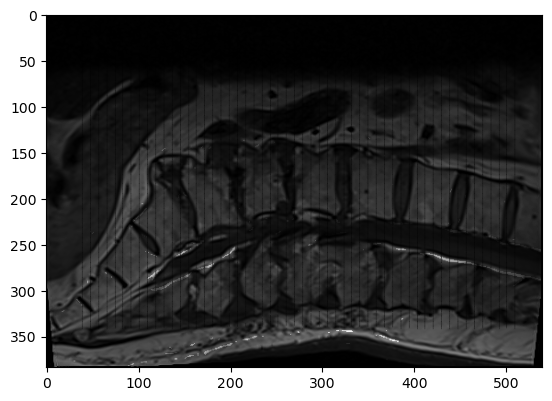

In [66]:
import matplotlib.pyplot as plt

plt.imshow(grid[0, 160, :, :], cmap="gray")

In [73]:
grid.shape

(2, 323, 384, 540)

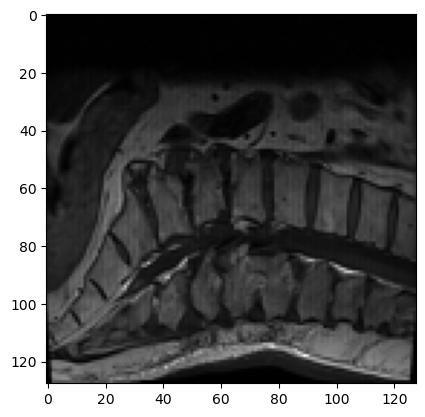

In [74]:
import torch.nn.functional as F

plt.imshow(F.adaptive_avg_pool3d(torch.HalfTensor(grid), (128, 128, 128))[0, int(160/323*128)], cmap="gray")